In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from spcqe.quantiles import SmoothPeriodicQuantiles, QUANTILES

In [2]:
def process_excel_file(file_name, year):
    # Check if the year is a leap year
    is_leap_year = (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    
    # Define the start and end of your time range
    start = pd.Timestamp(f'{year}-01-01 00:00:00')
    end = pd.Timestamp(f'{year}-12-31 23:00:00')
    
    # Create an hourly time index between start and end
    time_index = pd.date_range(start, end, freq='H')
    
    # Read the Excel file and select columns
    df = pd.read_excel(file_name, sheet_name='RI', usecols=['RT_Demand', 'Dry_Bulb', 'RT_LMP'])
    
    # Assign your new time index to your dataframe
    df.index = time_index
    
    return df

years = [2019, 2020, 2021, 2022]
paths = [Path() / 'fixtures' / f'{year}_smd_hourly.xlsx' for year in years]
df_list = [process_excel_file(path, year) for (path, year) in zip(paths, years)]

df = pd.concat(df_list)
df

,RT_Demand,RT_LMP,Dry_Bulb
2019-01-01 00:00:00,723.322,35.90,42
2019-01-01 01:00:00,688.771,38.81,44
2019-01-01 02:00:00,660.226,21.32,44
2019-01-01 03:00:00,642.773,18.52,46
2019-01-01 04:00:00,638.376,7.57,49
...,...,...,...
2022-12-31 19:00:00,876.594,26.33,49
2022-12-31 20:00:00,832.016,25.35,50
2022-12-31 21:00:00,793.269,31.66,49
2022-12-31 22:00:00,755.760,44.33,48


In [3]:
P1 = int(365*24)
P2 = int(7*24)
P3 = int(24)
K = 3
l = 0.1
spqs = [SmoothPeriodicQuantiles(K, [P1, P2, P3], quantiles=q, weight=l, verbose=False) for q in QUANTILES]
spqs[0]

SmoothPeriodicQuantiles(num_harmonics=3, periods=[8760, 168, 24],
                        quantiles=array([0.02]), weight=0.1)

In [38]:
spqs[3]

SmoothPeriodicQuantiles(num_harmonics=3, periods=[8760, 168, 24],
                        quantiles=array([0.3]), weight=0.1)

In [4]:
y1 = df['RT_Demand']
for spq in spqs:
    spq.fit(y1)
print(f"total time: {np.sum([spq.fit_time for spq in spqs]):.2f} seconds")

total time: 93.26 seconds


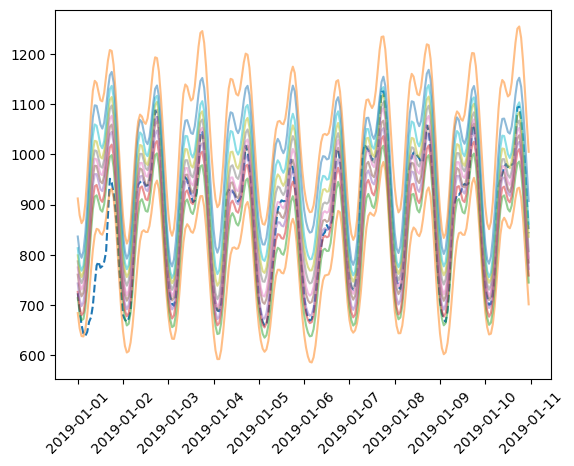

In [8]:
ix = 0
slc = np.s_[24 * ix:24 * (ix + 10)]
xs = df.index[slc]
plt.plot(xs, y1[slc], ls='--')
for spq in spqs:
    plt.plot(xs, spq.fit_quantiles[slc, :], alpha=0.5)
plt.xticks(rotation=45);

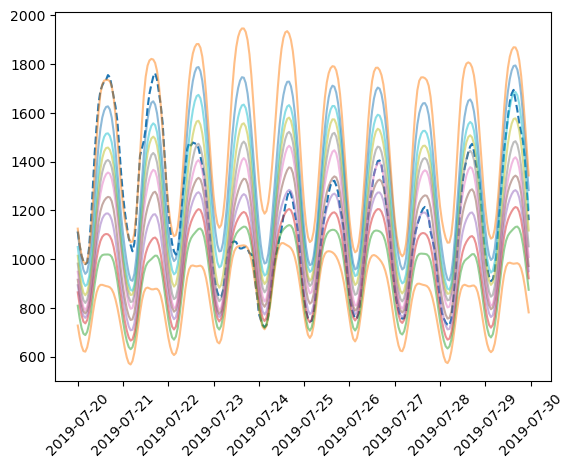

In [9]:
ix = 200
slc = np.s_[24 * ix:24 * (ix + 10)]
xs = df.index[slc]
plt.plot(xs, y1[slc], ls='--')
for spq in spqs:
    plt.plot(xs, spq.fit_quantiles[slc, :], alpha=0.5)
plt.xticks(rotation=45);

In [22]:
saved_quantiles = np.loadtxt('quantiles_saved.txt')
new_fit_quantiles = np.zeros_like(saved_quantiles)
for ix, spq in enumerate(spqs):
    new_fit_quantiles[:, ix] = spq.fit_quantiles.ravel()

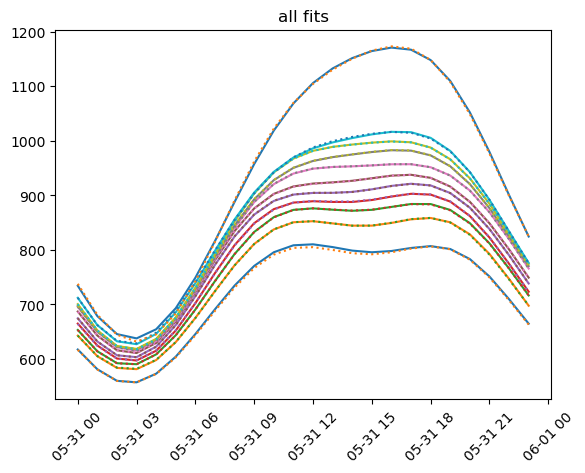

In [39]:
ix = 150
slc = np.s_[24 * ix:24 * (ix + 1)]
xs = df.index[slc]
slc2 = np.s_[:]
plt.plot(xs, saved_quantiles[slc, slc2], label='full fit')
plt.plot(xs, new_fit_quantiles[slc, slc2], ls=':', label='single fit')
# plt.legend()
plt.title("all fits")
plt.xticks(rotation=45);

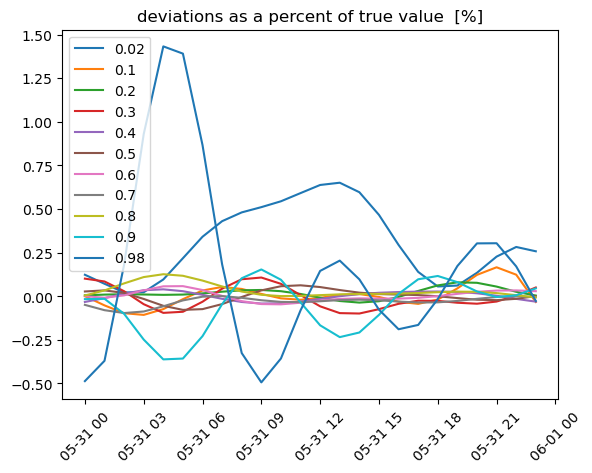

In [43]:
ix = 150
slc = np.s_[24 * ix:24 * (ix + 1)]
xs = df.index[slc]
slc2 = np.s_[:]
plt.plot(xs, 100 * (saved_quantiles[slc, slc2] - new_fit_quantiles[slc, slc2]) / saved_quantiles[slc, slc2])
plt.legend(QUANTILES)
plt.title("deviations as a percent of true value  [%]")
plt.xticks(rotation=45);